In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import h5py
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from predify.utils.training import train_pcoders, eval_pcoders

from networks_2022 import BranchedNetwork
from data.CleanSoundsDataset import CleanSoundsDataset

/home/es3773/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


# Choose which network you're running

In [2]:
args = []

In [3]:
from pbranchednetwork_all import PBranchedNetwork_AllSeparateHP
PNetClass = PBranchedNetwork_AllSeparateHP
pnet_name = 'all'
p_layers = 'All Layers'
args.append((PNetClass, pnet_name, p_layers))

In [4]:
from pbranchednetwork_a1 import PBranchedNetwork_A1SeparateHP
PNetClass = PBranchedNetwork_A1SeparateHP
pnet_name = 'a1'
p_layers = 'Layers 1-3'
args.append((PNetClass, pnet_name, p_layers))

In [5]:
from pbranchednetwork_conv1 import PBranchedNetwork_Conv1SeparateHP
PNetClass = PBranchedNetwork_Conv1SeparateHP
pnet_name = 'conv1'
p_layers = 'Layer 1'
args.append((PNetClass, pnet_name, p_layers))

# Parameters

In [6]:
exclude_timit = True

In [7]:
engram_dir = '/mnt/smb/locker/issa-locker/users/Erica/'

In [8]:
fig_dir = f'{engram_dir}hcnn/figures/'
pickle_dir = f'{engram_dir}hcnn/pickles/'

In [9]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

checkpoints_dir = f'{engram_dir}hcnn/checkpoints/'
tensorboard_dir = f'{engram_dir}hcnn/tensorboard/'

Device: cuda:0


# Helper functions

In [10]:
def load_pnet(PNetClass, pnet_name):
    net = BranchedNetwork(track_encoder_representations=True)
    net.load_state_dict(torch.load(f'{engram_dir}networks_2022_weights.pt'))
    pnet = PNetClass(net, build_graph=False)
    pnet.load_state_dict(torch.load(
        f"{checkpoints_dir}{pnet_name}/{pnet_name}-50-regular.pth",
        map_location='cpu'
        ))
    pnet.to(DEVICE)
    pnet.eval();
    print(f'Loaded Pnet: {pnet_name}')
    print_hps(pnet)
    return pnet

In [11]:
def print_hps(pnet):
    for pc in range(pnet.number_of_pcoders):
        print (f"PCoder{pc+1} : ffm: {getattr(pnet,f'ffm{pc+1}'):0.3f} \t fbm: {getattr(pnet,f'fbm{pc+1}'):0.3f} \t erm: {getattr(pnet,f'erm{pc+1}'):0.3f}")

In [53]:
# A few distance metrics

def rms(A, B, do_compare_rows=True):
    """
    RMS of flattened vectors
    """
    
    if torch.is_tensor(A):
        A = A.numpy()
    if torch.is_tensor(B):
        B = B.numpy()
    A = A.astype(float)
    B = B.astype(float)
    A = A.flatten()
    B = B.flatten()
        
    stim = A - B
    out = np.sqrt(np.mean(stim * stim))

    return out

def tanimoto_distance(A, B):
    """
    Tanimoto distance of flattened vector
    """
    
    if torch.is_tensor(A):
        A = A.numpy()
    if torch.is_tensor(B):
        B = B.numpy()
    A = A.astype(float)
    B = B.astype(float)
    A = A.flatten()
    B = B.flatten()
    
    _out = np.dot(A, B)/(np.linalg.norm(A)**2 + np.linalg.norm(B)**2 - np.dot(A,B))
    return _out
    
def cosine_similarity(A, B):
    """
    Cosine similarity of flattened vector
    """
    
    if torch.is_tensor(A):
        A = A.numpy()
    if torch.is_tensor(B):
        B = B.numpy()
    A = A.astype(float)
    B = B.astype(float)
    A = A.flatten()
    B = B.flatten()
    
    return np.dot(A, B)/(np.linalg.norm(A) * np.linalg.norm(B))

In [71]:
def eval_correlations(
    pnet, noise_std=80,
    exclude_timit=True
    ):
    
    if exclude_timit:
        dset_idxs = orig_dset=='WSJ'
    
    df_timesteps = []
    df_encoders = []
    df_correlations = []
    df_clean_accs = []
    df_pred_accs = []
    
    n_timesteps = 5

    dset_idxs = np.argwhere(dset_idxs).squeeze()
    for idx in dset_idxs:
        if np.random.uniform() < 0.8: continue # Throw out a chunk of the dataset for speed
        clean_input = clean_in[idx]
        clean_input = torch.tensor(clean_input.reshape((1, 1, 164, 400)))
        _input = clean_input.clone()
        clean_input = clean_input.to(DEVICE)
        pnet.reset()
        outputs, _ = pnet(clean_input)
        output = outputs.max(-1)[1].item()
        clean_acc = output == labels[idx]
        clean_repr_dict = pnet.backbone.encoder_repr
            
        pnet.reset()
        with torch.no_grad():
            base_rms = {}
            for j in range(n_timesteps):
                if j == 0:
                    _input = _input + torch.normal(0, noise_std, size=_input.shape)
                    _input = _input.to(DEVICE)
                else:
                    _input = None
                outputs, _ = pnet(_input)
                output = outputs.max(-1)[1].item()
                pred_acc = output == labels[idx]
                noisy_repr_dict = pnet.backbone.encoder_repr
                for enc_num, enc_name in enumerate(['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W']):
                    noisy_repr = noisy_repr_dict[enc_name]
                    clean_repr = clean_repr_dict[enc_name]
                    _rms = cosine_similarity(noisy_repr, clean_repr)
                    if j == 0:
                        base_rms[enc_name] = _rms
                    df_timesteps.append(j)
                    df_correlations.append(_rms/base_rms[enc_name])
                    df_clean_accs.append(clean_acc)
                    df_pred_accs.append(pred_acc)
                    df_encoders.append(enc_num+1)

    df = pd.DataFrame({
        'Timesteps': df_timesteps,
        'Correlation': df_correlations,
        'Clean Accuracy': df_clean_accs,
        'PNet Accuracy': df_pred_accs,
        'Encoder': df_encoders
    })
    return df

# Load PsychoPhysics Dataset

In [28]:
f_in = h5py.File(f"{engram_dir}PsychophysicsWord2017W_not_resampled.hdf5", 'r')

In [14]:
f_metadata = np.load(f"{engram_dir}PsychophysicsWord2017W_999c6fc475be1e82e114ab9865aa5459e4fd329d.__META.npy", 'r')

In [15]:
f_key = np.load(f"{engram_dir}PsychophysicsWord2017W_999c6fc475be1e82e114ab9865aa5459e4fd329d.__META_key.npy", 'r')

In [16]:
def getPsychophysics2017WCleanCochleagrams():
    
    cochleagrams_clean = []
   
    cochleagrams = []
    for batch_ii in range(0,15300,100):
        hdf5_path = '/mnt/smb/locker/issa-locker/users/Erica/cgrams_for_noise_robustness_analysis/PsychophysicsWord2017W_clean/batch_'+str(batch_ii)+'_to_'+str(batch_ii+100)+'.hdf5'
        with h5py.File(hdf5_path, 'r') as f_in:
            cochleagrams += list(f_in['data'])

    return cochleagrams
clean_in = getPsychophysics2017WCleanCochleagrams()

In [17]:
labels = []
for word in f_metadata['word']:
    idx = np.argwhere(f_key == word)
    if len(idx) == 0:
        labels.append(-1)
    else:
        labels.append(idx.item())
labels = np.array(labels)
labels += 1

In [18]:
orig_dset = []
for _orig_dset in f_metadata['orig_dset']:
    _orig_dset = str(_orig_dset, 'utf-8')
    _orig_dset = 'WSJ' if 'WSJ' in _orig_dset else 'Timit'
    orig_dset.append(_orig_dset)
orig_dset = np.array(orig_dset)

In [20]:
len(clean_in)

15300

In [21]:
labels.shape

(15262,)

In [22]:
orig_dset.shape

(15262,)

In [32]:
# This is bad practice! But the warnings are real annoying
import warnings
warnings.filterwarnings("ignore")

# All layers

In [78]:
arg = args[0]

In [79]:
PNetClass, pnet_name, p_layers = arg
pnet = load_pnet(PNetClass, pnet_name)
df = eval_correlations(
    pnet, noise_std=100,
    exclude_timit=exclude_timit
    )

Loaded Pnet: all
PCoder1 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder2 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder3 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder4 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder5 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010


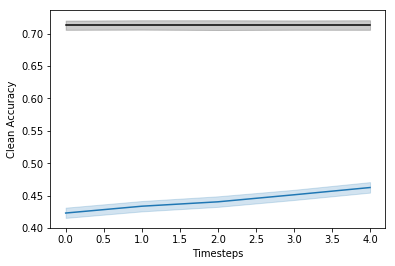

In [80]:
# Accuracy plots for sanity check
fig, ax = plt.subplots()
sns.lineplot(
    x='Timesteps', y='PNet Accuracy',
    data=df, ax=ax
)
sns.lineplot(
    x='Timesteps', y='Clean Accuracy',
    data=df, ax=ax, color='black'
)
plt.show()

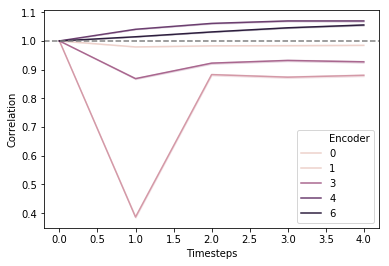

In [81]:
fig, ax = plt.subplots()
sns.lineplot(
    x='Timesteps', y='Correlation', hue='Encoder',
    data=df[df['Clean Accuracy']==False],
    ax=ax
    )
ax.axhline(1, color='gray', linestyle='--')
plt.show()

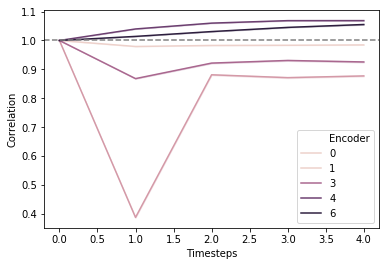

In [82]:
fig, ax = plt.subplots()
sns.lineplot(
    x='Timesteps', y='Correlation', hue='Encoder',
    data=df[df['Clean Accuracy']==True],
    ax=ax
    )
ax.axhline(1, color='gray', linestyle='--')
plt.show()

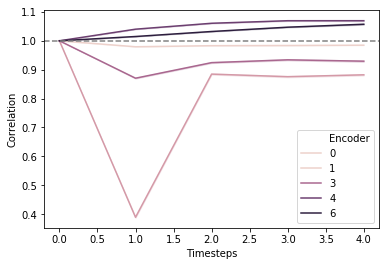

In [83]:
fig, ax = plt.subplots()
sns.lineplot(
    x='Timesteps', y='Correlation', hue='Encoder',
    data=df[df['PNet Accuracy']==False],
    ax=ax
    )
ax.axhline(1, color='gray', linestyle='--')
plt.show()

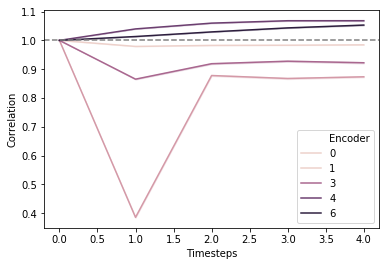

In [84]:
fig, ax = plt.subplots()
sns.lineplot(
    x='Timesteps', y='Correlation', hue='Encoder',
    data=df[df['PNet Accuracy']==True],
    ax=ax
    )
ax.axhline(1, color='gray', linestyle='--')
plt.show()

# A1

In [64]:
arg = args[1]

In [65]:
PNetClass, pnet_name, p_layers = arg
pnet = load_pnet(PNetClass, pnet_name)
df = eval_correlations(
    pnet, noise_std=80,
    exclude_timit=exclude_timit
    )

Loaded Pnet: a1
PCoder1 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder2 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder3 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010


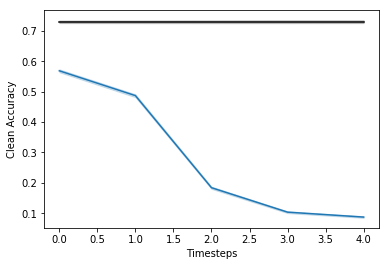

In [66]:
# Accuracy plots for sanity check
fig, ax = plt.subplots()
sns.lineplot(
    x='Timesteps', y='PNet Accuracy',
    data=df, ax=ax
)
sns.lineplot(
    x='Timesteps', y='Clean Accuracy',
    data=df, ax=ax, color='black'
)
plt.show()

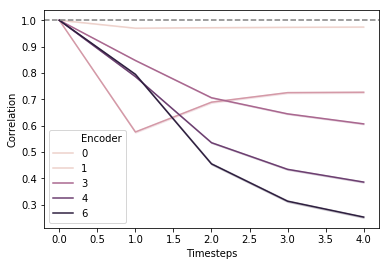

In [67]:
fig, ax = plt.subplots()
sns.lineplot(
    x='Timesteps', y='Correlation', hue='Encoder',
    data=df[df['Clean Accuracy']==False],
    ax=ax
    )
ax.axhline(1, color='gray', linestyle='--')
plt.show()

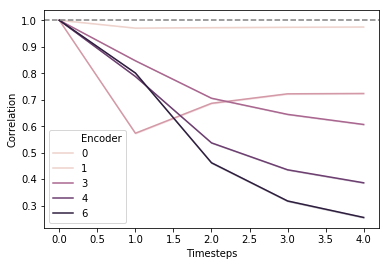

In [68]:
fig, ax = plt.subplots()
sns.lineplot(
    x='Timesteps', y='Correlation', hue='Encoder',
    data=df[df['Clean Accuracy']==True],
    ax=ax
    )
ax.axhline(1, color='gray', linestyle='--')
plt.show()

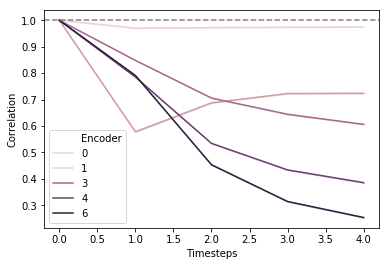

In [69]:
fig, ax = plt.subplots()
sns.lineplot(
    x='Timesteps', y='Correlation', hue='Encoder',
    data=df[df['PNet Accuracy']==False],
    ax=ax
    )
ax.axhline(1, color='gray', linestyle='--')
plt.show()

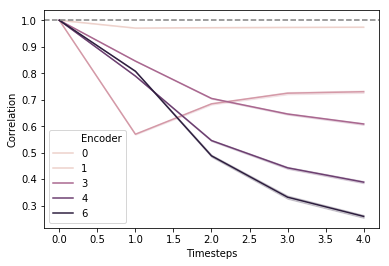

In [70]:
fig, ax = plt.subplots()
sns.lineplot(
    x='Timesteps', y='Correlation', hue='Encoder',
    data=df[df['PNet Accuracy']==True],
    ax=ax
    )
ax.axhline(1, color='gray', linestyle='--')
plt.show()